# STEP 3: Analyze candidates and select optimal partition

This is the final step where the output partitions are collected. From the collected partitions the ones that score best in terms of highest spatial precision and fewest missing values are selected.

# Packages

In [1]:
import itertools
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm
# from itertools import chain

from sqr.core.network import partition_surjective
from sqr.core.scoring import partition_score, get_undominated
from sqr.core.shape import  make_gdf_square_data
from sqr.miscellaneous import read_parse_mun
from sqr.core.config import cell_label, years

%matplotlib inline

# Load data 

#### Municipal data 

This data consists of the shape files for municipalities and muncipality data parsed to have square net information. 

In [2]:
gdf_kommuner = read_parse_mun()

#### Preprocessed data 

This data consists of the output from running 'Step 1: run assignments.'

In [3]:
other = 'data/temp_from_other/'
main = 'data/'
pareto = 'data/pareto/'

othernames = {'candidates_sub.hdf':['candidates_sub_aws.hdf','candidates_sub_mac.hdf','candidates_sub_oko4.hdf'],
              'candidates.hdf':['candidates_aws.hdf']}

filenames = {'candidates.hdf':['pareto.hdf','parsed/sqr_mun.hdf'], 
             'candidates_sub.hdf':['pareto_sub.hdf','parsed/sqr_mun_sub.hdf']}


### Merge multiple sources (optional)
If running the computation across multiple machines then various files can be merged. The code below may be helpful.

In [4]:
# def attemp_read(in_file, input_key):
#     try:
#         return pd.read_hdf(in_file, key=input_key)
#     except:
#         return pd.DataFrame()

In [5]:
# # list of files with output
# candidate files = 'candidates.hdf', 'candidates_sub.hdf'

# for filename in ['candidates.hdf']:
    
    
#     out_file = main+filename
    
#     in_files = [other+f for f in othernames[filename]]
#     input_keys = list(set(chain(*[pd.HDFStore(in_file).keys() for in_file in in_files])))


#     for input_key in input_keys:    
#         in_list = [attemp_read(f, input_key) for f in in_files]    
#         input_df = pd.concat(in_list)
        
#         try:
#             existing = pd.read_hdf(out_file, key=input_key)
#             out = pd\
#                     .concat([input_df, existing])\
#                     .drop_duplicates(subset='finish_ts')
#         except:
#             out = input_df
        
#         out.to_hdf(out_file, key=input_key)

# Select pareto

Compute Pareto frontier

In [6]:
for filename in ['candidates.hdf','candidates_sub.hdf']:
    
    in_file = main+filename
    out_file = main+filenames[filename][0]
    
    datastore = pd.HDFStore(in_file)
    datakeys = list(datastore.keys())
    datastore.close()
    
    for input_key in datakeys:
        print(input_key, out_file)
        input_df = pd.read_hdf(in_file, key=input_key)
        input_df = input_df.reset_index(drop=True)
        
        if input_df.shape[0]>1:
            out = get_undominated(input_df)
        else:
            out = input_df
        
        out.to_hdf(out_file, key=input_key)

/munidx219 data/pareto.hdf


C:\Users\bvq720\Anaconda3\envs\privacy_spatial\lib\site-packages\pandas\core\generic.py:2621: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['mun_idx', 'partition'], dtype='object')]

  encoding=encoding,


/munidx250 data/pareto.hdf
/munidx251 data/pareto.hdf
/munidx290 data/pareto.hdf
/munidx179_0 data/pareto_sub.hdf
/munidx179_1 data/pareto_sub.hdf
/munidx179_10 data/pareto_sub.hdf
/munidx179_11 data/pareto_sub.hdf
/munidx179_13 data/pareto_sub.hdf
/munidx179_14 data/pareto_sub.hdf
/munidx179_15 data/pareto_sub.hdf
/munidx179_16 data/pareto_sub.hdf
/munidx179_17 data/pareto_sub.hdf
/munidx179_18 data/pareto_sub.hdf
/munidx179_19 data/pareto_sub.hdf
/munidx179_2 data/pareto_sub.hdf
/munidx179_20 data/pareto_sub.hdf
/munidx179_21 data/pareto_sub.hdf
/munidx179_22 data/pareto_sub.hdf
/munidx179_23 data/pareto_sub.hdf
/munidx179_24 data/pareto_sub.hdf
/munidx179_3 data/pareto_sub.hdf
/munidx179_4 data/pareto_sub.hdf
/munidx179_5 data/pareto_sub.hdf
/munidx179_6 data/pareto_sub.hdf
/munidx179_7 data/pareto_sub.hdf
/munidx179_8 data/pareto_sub.hdf
/munidx179_9 data/pareto_sub.hdf


# Choose best partitions

In [7]:
def chain(l):
    return list(itertools.chain(*l))

Load populations

In [8]:
mun_pers = {}
mun_indices = {}

in_file = main+'candidates_sub.hdf'
mun_file = main+'parsed/sqr_mun_sub.hdf'

datastore = pd.HDFStore(in_file)
datakeys = list(datastore.keys())
datastore.close()

for input_key in datakeys:
    idx = input_key[7:]
    input_df = pd.read_hdf(in_file, key=input_key)
    mun_df = pd.read_hdf(mun_file, key='sqidx'+idx)

    mun_pers[idx] = mun_df.minimum_pers.sum()
    mun_indices[idx] = mun_df[cell_label].to_dict()
    
mun_file = main+'parsed/sqr_mun.hdf'    
datastore = pd.HDFStore(mun_file)
datakeys = list(datastore.keys())
datastore.close()
    
for input_key in datakeys:
    idx = input_key[6:]
    mun_df = pd.read_hdf(mun_file, key=input_key)
    mun_pers[idx] = mun_df.minimum_pers.sum()
    mun_indices[idx] = mun_df[cell_label].to_dict()

Load optimal partition mun-level

In [9]:
in_file = main+'pareto.hdf'
datastore = pd.HDFStore(in_file)
datakeys = list(datastore.keys())
datastore.close()


pareto = pd.concat([pd.read_hdf(in_file, k) for k in datakeys]).reset_index()
pareto.mun_idx = pareto.mun_idx.astype(int).astype(str)
pareto['score'] = pareto.apply(lambda row: partition_score(row.weighted_dist, 
                                                           row.count_nonzero_null, 
                                                           mun_pers[row.mun_idx]), 
                               axis=1)
optimals_idx = pareto.groupby('mun_idx').score.idxmax()
optimals = pareto.loc[optimals_idx]
optimals.partition = optimals.partition.apply(json.loads)

Load optimal partition sub mun-level

In [10]:
in_file = main+'pareto_sub.hdf'
datastore = pd.HDFStore(in_file)
datakeys = list(datastore.keys())
datastore.close()


pareto_sub = pd.concat([pd.read_hdf(in_file, k) for k in datakeys]).reset_index()
pareto_sub['score'] = pareto_sub\
                        .apply(lambda row: partition_score(row.weighted_dist, 
                                                           row.count_nonzero_null, 
                                                           mun_pers[row.mun_idx]),axis=1)

optimals_idx_sub = pareto_sub.groupby('mun_idx').score.idxmax()

optimals_sub = pareto_sub.loc[optimals_idx_sub.values].copy()
optimals_sub['pop_count'] = optimals_sub.mun_idx.apply(lambda m: mun_pers[m])
optimals_sub['mun'] = optimals_sub.mun_idx.apply(lambda s: s.split('_')[0])
optimals_sub.partition = optimals_sub.partition.apply(json.loads)

# remove køge
# optimals_sub = optimals_sub[~(optimals_sub['mun']=='163')]

gb_idx = optimals_sub.groupby('mun')
pop_sum = gb_idx.pop_count.sum()
na_sum = gb_idx.pers_nonzero_null.sum()
w_dist = gb_idx.apply(lambda g: (g.weighted_dist*g.pop_count).sum()/g.pop_count.sum())
partitions = gb_idx.partition.apply(chain)


optimals_sub_merg = pd.concat([na_sum,
                               pop_sum,
                               w_dist.rename('weighted_dist'),
                               partitions.rename('partition')],axis=1)

optimals_sub_merg['score'] = \
    optimals_sub_merg.apply(lambda row: partition_score(row.weighted_dist, 
                                                    row.pers_nonzero_null, 
                                                    row.pop_count),axis=1)

Comparison of partitions

In [11]:
merge_cols = ['score','partition','pers_nonzero_null','weighted_dist']
opt_mun = optimals.set_index('mun_idx')[merge_cols]
opt_sub = optimals_sub_merg[merge_cols]                              

merge = opt_mun.merge(opt_sub, how='outer', left_index=True,right_index=True).copy()
merge[['score_x','score_y']] = merge[['score_x','score_y']].fillna(-1)

In [12]:
def get_label(mun_idx, idx):
    return mun_indices[mun_idx][idx]

def get_labels(mun_idx, partition):
    return [[get_label(mun_idx,i) for i in g] for g in partition]

Select maximal scoring partitoin

In [13]:
optimal_indices = merge.apply(lambda row: row.partition_x if row.score_x>row.score_y else row.partition_y, axis=1)

optimal_labels =  optimal_indices\
                    .reset_index()\
                    .rename(columns={'index':'mun_idx',0:'partition'})\
                    .apply(lambda row: get_labels(str(row.mun_idx),row.partition),axis=1)

optimal_labels.index = optimal_indices.index.to_series().astype(int)
optimal_labels.sort_index(inplace=True)            
            
optimal_labels_one = list(itertools.chain(*optimal_labels.tolist()))

In [14]:
os.makedirs('data/output_final/', exist_ok=True)

with open ('data/output_final/partition.json', 'w') as f:
    f.write(json.dumps(optimal_labels_one))

# Analyze optimal partition

In [15]:
# optimal_miss = merge.apply(lambda row: row.pop_nonzero_null_x if row.score_x>row.score_y else row.pop_nonzero_null_y, axis=1)
# optimal_dist = merge.apply(lambda row: row.weighted_dist_x if row.score_x>row.score_y else row.weighted_dist_y, axis=1)

# optimal_stat = pd\
#                 .concat([optimal_miss,pd.Series(mun_pop),optimal_dist],axis=1)\
#                 .dropna()\
#                 .rename(columns={0:'miss',1:'total',2:'dist'})
            
# optimal_stat.index = optimal_stat.index.to_series().astype(int)

# optimal_stat.sort_index().to_csv('data/output_final/statistics.csv')

Check no duplicated

In [16]:
assignment_opt = pd.DataFrame([(i,j) for i,p in enumerate(optimal_labels_one) for j in p],
                              columns=['partition',cell_label])
is_assigned = list(itertools.chain(*optimal_labels_one))
is_assigned_ser = pd.Series(is_assigned)
is_assigned_ser.duplicated().sum()

0

Count population in partitions

In [19]:
distribution = {'hh':{}, 'pers':{}}
for label in 'hh', 'pers':

    pop_data = pd.read_hdf('data/parsed/KN100m_pop.hdf', key=label)

    assignment = dict([(i,g_idx) for g_idx,g in enumerate(optimal_labels_one) for i in g])
    pop_type_assign = pop_data.set_index(cell_label).join(pd.Series(assignment,name='assignment'))
    pop_type_assign = pop_type_assign[pop_type_assign.assignment.notnull()]
    
    distribution[label] = \
        pop_type_assign\
            .groupby('assignment')\
            .apply(lambda g: g[years].dropna(how='all',axis=1).sum(axis=0).min())

Verify population minimums

In [20]:
assert(min(distribution['pers'].min()>=100, distribution['hh'].min()>=50))

Make histograms for number of persons and households in the final partitions

C:\Users\bvq720\Anaconda3\envs\privacy_spatial\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:ylabel='Frequency'>

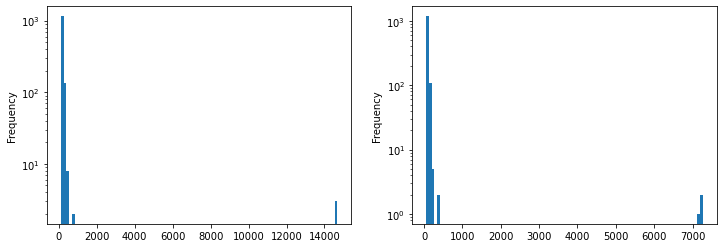

In [22]:
f,ax = plt.subplots(1,2, figsize=(12,4))
distribution['pers'].plot.hist(bins=100,log=True, ax=ax[0])
distribution['hh'].plot.hist(bins=100,log=True, ax=ax[1])

Count unassigned population for each year

In [23]:
from sqr.core.config import mean_cols, minimum_cols

info = []
for idx, row in gdf_kommuner.iterrows():        
    info += [pd.read_hdf(mun_file, key=f'sqidx{idx}').assign(KOMNAVN=row.KOMNAVN)]
kominfo = pd.concat(info)

In [24]:
kominfo[~kominfo[cell_label].isin(is_assigned)]\
.groupby(['KOMNAVN'])\
[mean_cols+minimum_cols]\
.agg(['sum', 'mean'])

mean_pers           mean_hh           minimum_pers            \
                    sum      mean     sum      mean          sum      mean   
KOMNAVN                                                                      
Albertslund       306.5  3.605882   159.4  1.875294        110.0  1.294118   
Ballerup          118.6  3.041026    62.0  1.589744         36.0  0.923077   
Bornholm          827.6  1.501996   410.2  0.744465        110.0  0.199637   
Brøndby            50.1  2.178261    29.0  1.260870         11.0  0.478261   
Frederiksberg       5.4  5.400000     3.2  3.200000          1.0  1.000000   

              minimum_hh            
                     sum      mean  
KOMNAVN                             
Albertslund         38.0  0.447059  
Ballerup            12.0  0.307692  
Bornholm            20.0  0.036298  
Brøndby              1.0  0.043478  
Frederiksberg        0.0  0.000000

C:\Users\bvq720\Anaconda3\envs\privacy_spatial\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

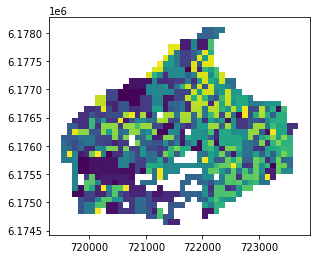

In [27]:
gdf_k = make_gdf_square_data(kominfo[kominfo.KOMNAVN=='Frederiksberg'])
gdf_k.merge(assignment_opt).plot(column='partition')

In [26]:
kominfo[~kominfo[cell_label].isin(is_assigned)]\
.groupby(['KOMNAVN'])\
[mean_cols+minimum_cols]\
.agg(['sum', 'mean'])

mean_pers           mean_hh           minimum_pers            \
                    sum      mean     sum      mean          sum      mean   
KOMNAVN                                                                      
Albertslund       306.5  3.605882   159.4  1.875294        110.0  1.294118   
Ballerup          118.6  3.041026    62.0  1.589744         36.0  0.923077   
Bornholm          827.6  1.501996   410.2  0.744465        110.0  0.199637   
Brøndby            50.1  2.178261    29.0  1.260870         11.0  0.478261   
Frederiksberg       5.4  5.400000     3.2  3.200000          1.0  1.000000   

              minimum_hh            
                     sum      mean  
KOMNAVN                             
Albertslund         38.0  0.447059  
Ballerup            12.0  0.307692  
Bornholm            20.0  0.036298  
Brøndby              1.0  0.043478  
Frederiksberg        0.0  0.000000

Distribution of unassigned persons and households

C:\Users\bvq720\Anaconda3\envs\privacy_spatial\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\bvq720\Anaconda3\envs\privacy_spatial\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


hh
4172    7343
4835      33
4815      28
4796      17
2121      13
dtype: int64


pers
4173    14538
4816       65
4836       65
4797       39
2121       29
dtype: int64




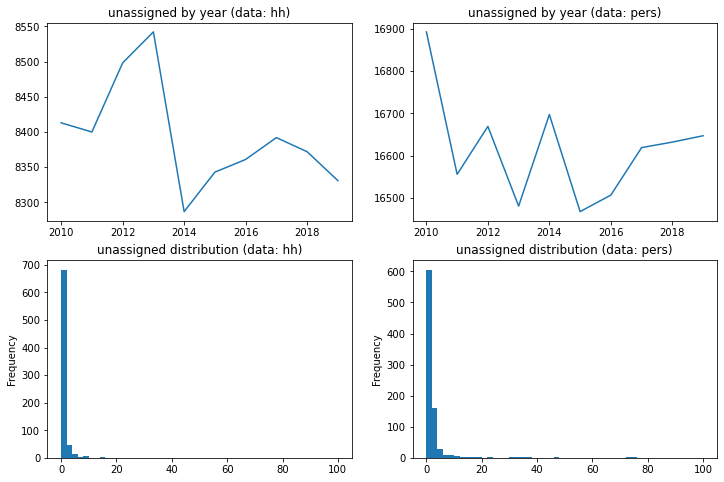

In [80]:
f,ax = plt.subplots(2,2,figsize=(12,8))

for i, label in enumerate(['hh', 'pers']):
    pop_data = pd.read_hdf('data/parsed/KN100m_pop.hdf', key=label)
    pop_unassigned_years = pop_data[~pop_data[cell_label].isin(is_assigned)][years].fillna(0)
    pop_unassigned_years.sum(axis=0).plot(ax=ax[0][i], title=f'unassigned by year (data: {label})')
    
    pop_unassigned = pop_data[~pop_data[cell_label].isin(is_assigned)][years].fillna(0).mean(axis=1)
    pop_unassigned.plot.hist(bins=50,range=[0,100], ax=ax[1][i], title=f'unassigned distribution (data: {label})')
    
    largest = pop_data[~pop_data[cell_label].isin(is_assigned)].min(1).nlargest(5)
    
    print(label)
    print(largest)
    print('\n')
    